<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/MEGprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Setting up the Colab page to use neqsim
%%capture
!pip install neqsim
#!pip install neqsim==3.0.19
import neqsim
from neqsim.thermo.thermoTools import *

# MEG for hydrate inhibition and regeneration of MEG

**Introduction**

Monoethylene glycol (MEG) is commonly used in the oil and gas industry for hydrate inhibition in pipelines and process equipment. This process involves injecting MEG into the gas stream to prevent hydrate formation. After use, the MEG is regenerated to remove water and maintain its effectiveness. This notebook explores the principles of MEG for hydrate inhibition and regeneration, including:

* **Hydrate Formation:** Understanding the conditions that lead to hydrate formation in natural gas systems.
* **MEG Inhibition:** How MEG prevents hydrate formation by lowering the hydrate formation temperature.
* **MEG Regeneration:** Methods for removing water from MEG to restore its hydrate inhibition properties.
* **Case Studies:** Examples of MEG applications in real-world scenarios.

# Litterature

Wikipedia

https://en.wikipedia.org/wiki/Ethylene_glycol


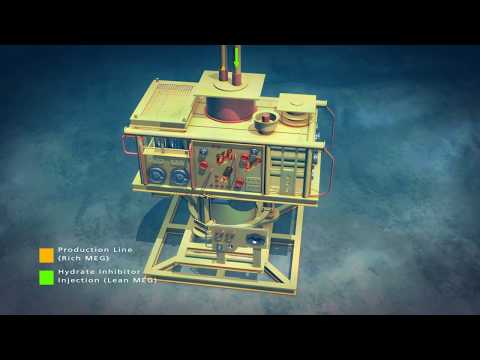

In [10]:
#@title MEG reclamation
#@markdown This video gives an intriduction to MEG reclamation
from IPython.display import YouTubeVideo
YouTubeVideo('4HosHcGvtVM', width=600, height=400)

# Simulation of rich-MEG regeneration
This notebook focuses on simulating the regeneration process of rich MEG. Rich MEG is the MEG solution after it has absorbed water during hydrate inhibition. The regeneration process aims to remove this water to restore the MEG's effectiveness. The notebook will explore the principles behind MEG regeneration using a distillation column and analyze the impact of key parameters like reflux rate and reboiler temperature on the process performance.

In [11]:
from neqsim.process import *
from neqsim.thermo.thermoTools import fluid, TPflash
from neqsim import jneqsim as neqsim
from neqsim.thermo import thermodynamicoperations

# -----------------------------------------------------------------------------
# 1) Create fluid (equivalent to new SystemSrkCPAstatoil(273.15 + 40, 6.0))
# -----------------------------------------------------------------------------
# Define the fluid model and initial conditions (temperature and pressure) for the rich MEG stream.
fluid1 = fluid('cpa', temperature=273.15 + 40.0, pressure=6.0)

# 2) Add components
# Add the chemical components present in the rich MEG stream with their initial mole fractions.
fluid1.addComponent("nitrogen", 0.1)
fluid1.addComponent("CO2", 0.05)
fluid1.addComponent("methane", 9.0)
fluid1.addComponent("ethane", 0.5)
fluid1.addComponent("propane", 0.3)
fluid1.addComponent("water", 75.0)
fluid1.addComponent("MEG", 25.0)

# 3) Set mixing rule
# Specify the thermodynamic mixing rule to be used for property calculations.
fluid1.setMixingRule(10)  # 10 => classic CPA mixing rule

# 4) Perform a TP flash
# Perform a temperature-pressure flash calculation to determine the phase equilibrium of the fluid.
TPflash(fluid1)

# 5) Extract phases as separate SystemInterfaces
# Separate the fluid into its equilibrium phases (gas and liquid) for further processing.
#    phaseToSystem(0) => likely the gas phase
#    phaseToSystem(1) => likely the liquid phase
feedGas = fluid1.phaseToSystem(0)
feedMEG = fluid1.phaseToSystem(1)

# 6) Calculate weight fraction of MEG in the second phase
# Calculate the weight percentage of MEG in the liquid (MEG-rich) phase.
wtMEG = feedMEG.getPhase(0).getWtFrac("MEG") * 100.0

# Clear any existing process in neqsim.
clearProcess()
# -----------------------------------------------------------------------------
# 7) Create process streams
# -----------------------------------------------------------------------------
# Define the rich MEG feed stream entering the regeneration process.
stream1 = stream("stream 1", feedMEG)
stream1.setFlowRate(6000.0, "kg/hr")
stream1.setTemperature(80.0, "C")
stream1.setPressure(1.021, "bara")
stream1.run()

# Define the stripping gas stream used in the regeneration process.
stripgas = stream("stream 2", feedGas)
stripgas.setFlowRate(10.0, "kg/hr")
stripgas.setTemperature(80.0, "C")
stripgas.setPressure(1.021, "bara")
stripgas.run()

# -----------------------------------------------------------------------------
# 8) Create and configure the distillation column
# -------------------------------------------------------------
# Create a distillation column object for MEG regeneration.
distillationColumn = neqsim.process.equipment.distillation.DistillationColumn("MEG column", 2, True, True)
# Add the rich MEG feed stream to the distillation column.
distillationColumn.addFeedStream(stream1, 1)
# Add the stripping gas stream to the distillation column.
distillationColumn.addFeedStream(stripgas, 1)

# Set the operating temperature of the reboiler (bottom of the column).
distillationColumn.getReboiler().setOutTemperature(273.15 + 140.0)  # 140 C
# Set the operating temperature of the condenser (top of the column).
distillationColumn.getCondenser().setOutTemperature(273.15 + 35.0)  # 35 C

# Set the pressure at the top and bottom of the distillation column.
distillationColumn.setTopPressure(1.021)
distillationColumn.setBottomPressure(1.021)

# Enable liquid reflux in the condenser and set the reflux flow rate.
distillationColumn.getCondenser().setSeparation_with_liquid_reflux(True,
                                                                   370.0,
                                                                   "kg/hr")
# 9) Run the column simulation
# Run the simulation of the distillation column to calculate outlet streams and conditions.
distillationColumn.run()

In [12]:
print(f"""
---------- PROCESS RESULTS ----------
wt% MEG in feed : {wtMEG} kg/m3
density aqueous feed: {stream1.getFluid().getPhase("aqueous").getDensity('kg/m3')} kg/m3
Distillation column top gas flow: {distillationColumn.getGasOutStream().getFlowRate('kg/hr')} kg/hr
Distillation column top temperature: {distillationColumn.getGasOutStream().getTemperature('C')} °C
Distillation column bottom liquid flow: {distillationColumn.getLiquidOutStream().getFlowRate('kg/hr')} kg/hr
Split to water treatment: {distillationColumn.getCondenser().getLiquidProductStream().getFlowRate('kg/hr')} kg/hr
Split to recycle to column: {distillationColumn.getCondenser().getLiquidOutStream().getFlowRate('kg/hr')} kg/hr
wt% MEG to water treatment: {distillationColumn.getCondenser().getLiquidProductStream().getFluid().getPhase(0).getWtFrac('MEG') * 100.0} wt%
flow MEG to water treatment: {distillationColumn.getCondenser().getLiquidProductStream().getFluid().getComponent('MEG').getFlowRate('kg/hr')} kg/hr
density reflux: {distillationColumn.getCondenser().getLiquidProductStream().getFluid().getDensity('kg/m3')} kg/m3
wt% MEG in bottom: {distillationColumn.getLiquidOutStream().getFluid().getPhase(0).getWtFrac('MEG') * 100.0} wt%
KOF: {distillationColumn.getCondenser().getLiquidProductStream().getFluid().getPhase(0).getWtFrac('MEG') * 1.0e6 / 1.547} KOF
Reboiler duty: {distillationColumn.getReboiler().getDuty() / 1.0e6} MW
Condenser duty: {distillationColumn.getCondenser().getDuty() / 1.0e6} MW
Reboiler temperature: {distillationColumn.getReboiler().getTemperature()-273.15} °C
Tray 1 temperature: {distillationColumn.getTray(1).getTemperature()-273.15} °C
Tray 2 temperature: {distillationColumn.getTray(2).getTemperature()-273.15} °C
Condenser temperature: {distillationColumn.getCondenser().getTemperature()-273.15} °C
""".strip())

---------- PROCESS RESULTS ----------
wt% MEG in feed : 53.474322769712124 kg/m3
density aqueous feed: 1019.2053713967284 kg/m3
Distillation column top gas flow: 11.658702792026961 kg/hr
Distillation column top temperature: 35.0 °C
Distillation column bottom liquid flow: 3517.716328285497 kg/hr
Split to water treatment: 2480.895531377659 kg/hr
Split to recycle to column: 370.00000000000006 kg/hr
wt% MEG to water treatment: 0.7083088174011076 wt%
flow MEG to water treatment: 17.572401799258024 kg/hr
density reflux: 992.5716871391905 kg/m3
wt% MEG in bottom: 90.73964388660487 wt%
KOF: 4578.596104725972 KOF
Reboiler duty: 1.8501984244842364 MW
Condenser duty: -1.9656028975047577 MW
Reboiler temperature: 140.0 °C
Tray 1 temperature: 111.7095826102829 °C
Tray 2 temperature: 103.1143415033186 °C
Condenser temperature: 35.0 °C


# Printing streams

In [13]:
printFrame(distillationColumn.getCondenser().getFluid())
printFrame(distillationColumn.getReboiler().getFluid())

| 0                    | 1          | 2                    | 3                    | 4   | 5   | 6               |
|:---------------------|:-----------|:---------------------|:---------------------|:----|:----|:----------------|
|                      | total      | GAS                  | AQUEOUS              |     |     |                 |
| nitrogen             | 3.69474E-5 | 9.01916E-3           | 9.24265E-8           |     |     | [mole fraction] |
| CO2                  | 4.1378E-5  | 9.21155E-3           | 3.75185E-6           |     |     | [mole fraction] |
| methane              | 3.47931E-3 | 8.46626E-1           | 1.97892E-5           |     |     | [mole fraction] |
| ethane               | 2.08449E-4 | 5.05584E-2           | 1.85784E-6           |     |     | [mole fraction] |
| propane              | 1.19612E-4 | 2.91947E-2           | 3.13842E-7           |     |     | [mole fraction] |
| water                | 9.94057E-1 | 5.53899E-2           | 9.97908E-1           |     

# Run studies to evaluate MEG to water treatment plant

## Study to see effect of reflux rate from 300 kg/hr to 1300 kg/hr

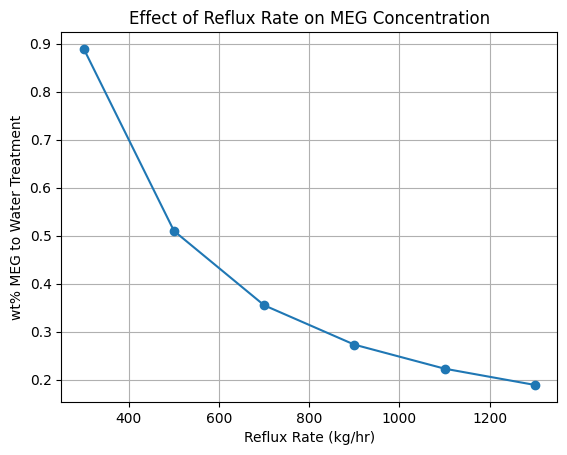

In [14]:
import matplotlib.pyplot as plt
import numpy as np

reflux_rates = np.arange(300, 1301, 200)  # Reflux rates from 300 to 1300 kg/hr
meg_wt_percentages = []
reflux_rates_solved = []

for reflux_rate in reflux_rates:
    # Set reflux rate for the distillation column
    distillationColumn.getCondenser().setSeparation_with_liquid_reflux(True, reflux_rate, "kg/hr")

    # Run the column simulation
    distillationColumn.run()

    if distillationColumn.solved():
      # Calculate and store wt% MEG to water treatment
      reflux_rates_solved.append(reflux_rate)
      meg_wt_percentage = distillationColumn.getCondenser().getLiquidProductStream().getFluid().getPhase(0).getWtFrac('MEG') * 100.0
      meg_wt_percentages.append(meg_wt_percentage)

# Plotting the results
plt.plot(reflux_rates_solved, meg_wt_percentages, marker='o')
plt.xlabel("Reflux Rate (kg/hr)")
plt.ylabel("wt% MEG to Water Treatment")
plt.title("Effect of Reflux Rate on MEG Concentration")
plt.grid(True)
plt.show()

## Study to see effect of reflux rate from 3% to 12% of feed flow rate

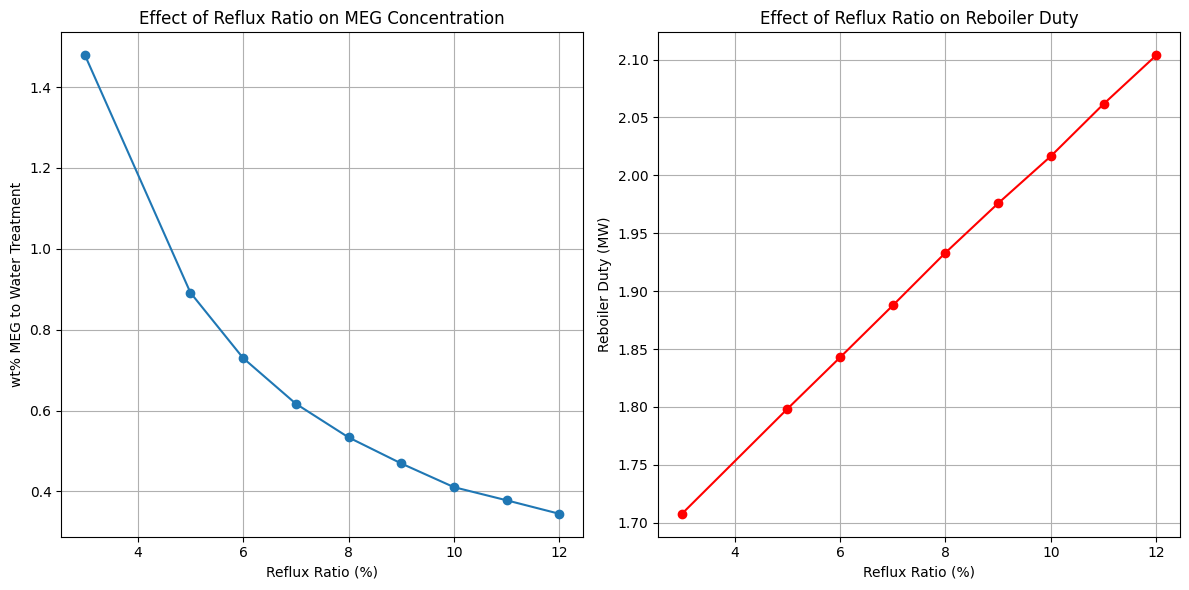

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get the feed flow rate
feed_flow_rate = stream1.getFlowRate("kg/hr")

# Define reflux ratios (3% to 12%)
reflux_ratios = np.arange(0.03, 0.13, 0.01)

reflux_ratios_solved = []
meg_wt_percentages = []
reboiler_duties = []

for reflux_ratio in reflux_ratios:
    # Calculate reflux rate based on reflux ratio and feed flow rate
    reflux_rate = reflux_ratio * feed_flow_rate

    # Set reflux rate for the distillation column
    distillationColumn.getCondenser().setSeparation_with_liquid_reflux(True, reflux_rate, "kg/hr")

    # Run the column simulation
    distillationColumn.run()

    # Calculate and store wt% MEG to water treatment
    if distillationColumn.solved():
      reflux_ratios_solved.append(reflux_ratio*100)
      meg_wt_percentage = distillationColumn.getCondenser().getLiquidProductStream().getFluid().getPhase(0).getWtFrac('MEG') * 100.0
      meg_wt_percentages.append(meg_wt_percentage)
      reboiler_duty = distillationColumn.getReboiler().getDuty() / 1.0e6  # Convert to MW
      reboiler_duties.append(reboiler_duty)

# Plotting the results for MEG concentration
plt.figure(figsize=(12, 6))  # Adjust figure size if needed
plt.subplot(1, 2, 1)  # Create a subplot for MEG concentration
plt.plot(reflux_ratios_solved, meg_wt_percentages, marker='o')
plt.xlabel("Reflux Ratio (%)")
plt.ylabel("wt% MEG to Water Treatment")
plt.title("Effect of Reflux Ratio on MEG Concentration")
plt.grid(True)

# Plotting the results for reboiler duties
plt.subplot(1, 2, 2)  # Create a subplot for reboiler duties
plt.plot(reflux_ratios_solved, reboiler_duties, marker='o', color='r')  # Use red color for reboiler duties
plt.xlabel("Reflux Ratio (%)")
plt.ylabel("Reboiler Duty (MW)")
plt.title("Effect of Reflux Ratio on Reboiler Duty")
plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

# wt% of lean MEG as function of reboiler temperature

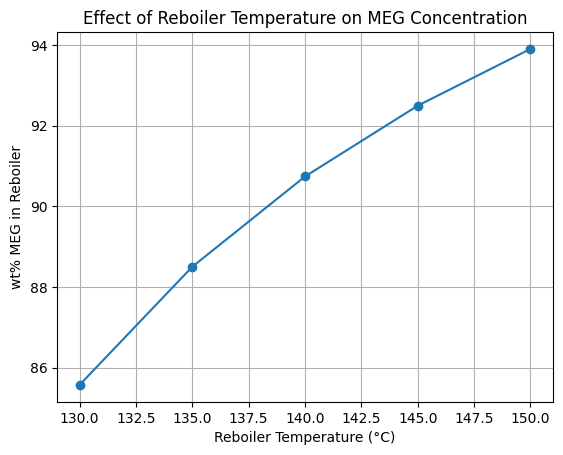

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Define the temperature range for the reboiler
reboiler_temperatures = np.arange(130, 151, 5)  # Temperatures from 100 to 180 °C

meg_wt_percentages = []
reboiler_temperatures_solved = []

distillationColumn.getCondenser().setSeparation_with_liquid_reflux(True, 1000.0, "kg/hr")

for reboiler_temperature in reboiler_temperatures:
    # Set the reboiler temperature
    distillationColumn.getReboiler().setOutTemperature(273.15 + reboiler_temperature)

    # Run the column simulation
    distillationColumn.run()

    meg_wt_percentage = distillationColumn.getLiquidOutStream().getFluid().getPhase(0).getWtFrac('MEG') * 100.0
    meg_wt_percentages.append(meg_wt_percentage)
    reboiler_temperatures_solved.append(reboiler_temperature)

# Plotting the results
plt.plot(reboiler_temperatures_solved, meg_wt_percentages, marker='o')
plt.xlabel("Reboiler Temperature (°C)")
plt.ylabel("wt% MEG in Reboiler")
plt.title("Effect of Reboiler Temperature on MEG Concentration")
plt.grid(True)
plt.show()